In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import random
from operator import itemgetter

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.svm import LinearSVC

import cv2

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

from itertools import count
iid = count()

SEED = 42    # random state seed for consistent results

### 0. Preprocessing

In [2]:
%%time
# mini_X = np.loadtxt("./Datasets/mini_train_x.csv", delimiter=",")
# mini_y = np.loadtxt("./Datasets/mini_train_y.csv", delimiter=",")

mini_X = np.loadtxt("./Datasets/train_med_x.csv", delimiter=",")
mini_y = np.loadtxt("./Datasets/train_med_y.csv", delimiter=",")

# mini_X = np.loadtxt("./Datasets/train_x.csv", delimiter=",")
# mini_y = np.loadtxt("./Datasets/train_y.csv", delimiter=",")

Wall time: 12.1 s


#### Reshape to easily visualize while cleaning data

In [3]:
%%time
x = mini_X.reshape(-1, 64, 64)

imgs = []
for idx in range(len(x)):
    img_id = next(iid)
    cv2.imwrite('Output/{}.jpg'.format(img_id), 255-x[idx])
    imgs.append(cv2.imread('Output/{}.jpg'.format(img_id), 0))

Wall time: 19 s


We will first transform to binary image (black, white):

In [4]:
%%time
bin_imgs = []
for img in imgs:
    _, bin_img = cv2.threshold(img, 50, 255, cv2.THRESH_BINARY)
    bin_imgs.append(bin_img)

Wall time: 19 ms


Then we will remove the noice by dilatating and eroding the image:

In [5]:
%%time
denoised_imgs = []
for bin_img in bin_imgs:
    dilatated = cv2.dilate(bin_img, np.ones((3,3)))
    denoised_imgs.append(cv2.erode(dilatated, np.ones((2,2))))

Wall time: 142 ms


Finally, find largest contour:

In [6]:
%%time
MAX_AREA = 60*60   # avoid getting the 64X64 image as a contour
def get_coords_largest_digit(contours):
    max_contour = 0
    for idx, cont in enumerate(contours):
        a = cv2.contourArea(cont,False)
        if a > max_contour and a < MAX_AREA:
            x,y,w,h = cv2.boundingRect(cont)
            max_contour = a

    return x,y,w,h
 
discarted = 0
MAX_ALLOWED_LENGTH = 36
largest_digits = []
idx_to_del = []
for idx, img in enumerate(denoised_imgs.copy()):
    _, contours, _ = cv2.findContours(img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    
    x,y,w,h = get_coords_largest_digit(contours)
    cropped_img = img[y+1:y+h, x+1:x+w]
    
    vertical = int((MAX_ALLOWED_LENGTH-h) / 2)
    horizontal = int((MAX_ALLOWED_LENGTH-w) / 2)

    if h > MAX_ALLOWED_LENGTH or w > MAX_ALLOWED_LENGTH:
        discarted +=1
        idx_to_del.append(idx)
        continue

    resized_img = cv2.copyMakeBorder(cropped_img,vertical,vertical,horizontal,horizontal,cv2.BORDER_CONSTANT, value=[255,255,255])
    largest_digits.append(resized_img[2:34,2:34])
    
mini_y = np.delete(mini_y, idx_to_del, axis=0)

print('Discarted {} samples because preprocessing failed to clean well the image.'.format(discarted))

Discarted 64 samples because preprocessing failed to clean well the image.
Wall time: 169 ms


Lets visualize the transformations:

4 5


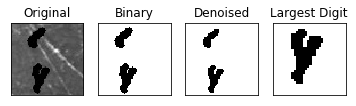

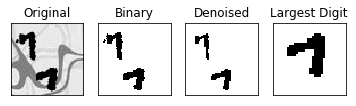

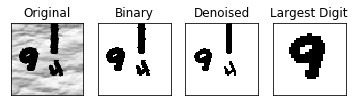

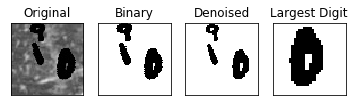

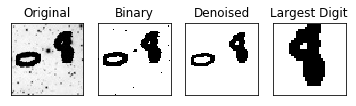

In [7]:
def plot_images(images, titles):
    cols = len(images)
    rows = len(images[0])
    
    print(cols, rows)
    for r in range(rows):
        for c in range(cols):
            plt.subplot(1,cols,c+1)
            plt.imshow(images[c][r],'gray')
            plt.title(titles[c])
            plt.xticks([]),plt.yticks([])
        
        plt.show()
        
titles = ['Original', 'Binary', 'Denoised', 'Largest Digit']
images = [imgs[:5], bin_imgs[:5], denoised_imgs[:5], largest_digits[:5]]
plot_images(images, titles)

#### Split the clean data

In [8]:
clean_X = []
for i in range(len(largest_digits)):
    clean_X.append(largest_digits[i].flatten())

clean_X = np.divide(255-np.array(clean_X),255)

mini_X_train, mini_X_test, mini_y_train, mini_y_test = train_test_split(clean_X, mini_y, 
                                                                        test_size=0.3,
                                                                       random_state=SEED)

### 1. Linear Learners

In [9]:
%%time
# hyperparameter permutations
FOLDS = 3 
DUAL = [False] 
LOSSES = ['squared_hinge','hinge']
PENALTIES = ['l1','l2']
SOLVERS = ['lbfgs']

KFOLD = KFold(n_splits=FOLDS, random_state=SEED)

Wall time: 0 ns


#### Base and dummy clf performances for reference

In [10]:
%%time
# dummy clf performance
random_clf = DummyClassifier(random_state=42)
result = cross_val_score(random_clf, mini_X_train, mini_y_train, cv=KFOLD, scoring='accuracy')
print('Random clf performance: {:.4f}'.format(result.mean()))

# Base performance (default HP)
result = cross_val_score(LinearSVC(), mini_X_train, mini_y_train, cv=KFOLD, scoring='accuracy')
print('LinearSVM base performance: {:.4f}'.format(result.mean()))

result = cross_val_score(LogisticRegression(), mini_X_train, mini_y_train, cv=KFOLD, scoring='accuracy')
print('LogReg base performance: {:.4f}'.format(result.mean()))

Random clf performance: 0.0973
LinearSVM base performance: 0.3583
LogReg base performance: 0.4460
Wall time: 15.8 s


#### Perform Model Selection for LinearSM

In [11]:
%%time
parameters = {'C':np.linspace(0.0005,0.001, 10)}
svc = LinearSVC()
clf = GridSearchCV(svc, parameters, scoring='accuracy')
clf.fit(mini_X_train,mini_y_train)
print('HyperParameters chosen by CV: {}'.format(clf.best_params_ ))
print('Testing Score: {:.4f}'.format(clf.score(mini_X_test, mini_y_test)))

HyperParameters chosen by CV: {'C': 0.0009444444444444445}
Testing Score: 0.5733
Wall time: 4.66 s


#### Perform Model Selection for LogisticRegression

In [12]:
%%time

parameters = {'C':np.linspace(0.005,0.02, 10),'solver':SOLVERS,'n_jobs':[8]}
logit = LogisticRegression()
clf = GridSearchCV(logit, parameters, scoring='accuracy')
clf.fit(mini_X_train,mini_y_train)
print('HyperParameters chosen by CV: {}'.format(clf.best_params_ ))
print('Testing Score: {:.4f}'.format(clf.score(mini_X_test, mini_y_test)))

HyperParameters chosen by CV: {'C': 0.009999999999999998, 'n_jobs': 8, 'solver': 'lbfgs'}
Testing Score: 0.6023
Wall time: 3min 39s


### Convolutional Neural Network

In [13]:
# import torch 
# from torch.autograd import Variable

# # run on GPU if CUDA available
# # dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
# dtype = torch.FloatTensor

In [14]:
# %%time
# N, D_in, H, D_out =  len(mini_X_train), len(mini_X_train[0]), 200, len(mini_X_train)

# x_tensor = torch.from_numpy(mini_X_train).type(dtype)
# y_tensor = torch.from_numpy(mini_y_train).type(dtype)

# x = Variable(x_tensor, requires_grad=False)
# y = Variable(y_tensor, requires_grad=False)

# w1 = Variable(torch.randn(D_in, H).type(dtype), requires_grad=True)
# w2 = Variable(torch.randn(H, D_out).type(dtype), requires_grad=True)

# learning_rate = 1e-6
# for t in range(500):
#     # Forward Pass
#     y_pred = x.mm(w1).clamp(min=0).mm(w2)

#     # Compute loss
#     # Now loss is a Variable of shape (1,) and loss.data is a Tensor of shape
#     # (1,); loss.data[0] is a scalar value holding the loss.
#     loss = (y_pred - y).pow(2).sum()
#     if t % 50 == 0: print('[{}] {}'.format(t, loss.data[0]))

#     # Baackwards Pass
#     loss.backward()

#     # Update weights using gradient descent
#     w1.data -= learning_rate * w1.grad.data
#     w2.data -= learning_rate * w2.grad.data

#     # Manually zero the gradients after updating weights
#     w1.grad.data.zero_()
#     w2.grad.data.zero_()

In [15]:
# # Hyper Parameters
# num_epochs = 5
# batch_size = 100
# learning_rate = 0.001

# print(x_tensor.shape)
# print(y_tensor.shape)


# train_loader = torch.utils.data.DataLoader(dataset=(x_tensor, y_tensor),
#                                            batch_size=batch_size, 
#                                            shuffle=True)

# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()
#         self.layer1 = nn.Sequential(
#             nn.Conv2d(1, 16, kernel_size=5, padding=2),
#             nn.BatchNorm2d(16),
#             nn.ReLU(),
#             nn.MaxPool2d(2))
#         self.layer2 = nn.Sequential(
#             nn.Conv2d(16, 32, kernel_size=5, padding=2),
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.MaxPool2d(2))
#         self.fc = nn.Linear(7*7*32, 10)
        
#     def forward(self, x):
#         out = self.layer1(x)
#         out = self.layer2(out)
#         out = out.view(out.size(0), -1)
#         out = self.fc(out)
#         return out
        
# cnn = CNN()

# # Loss and Optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)

In [16]:
# # Train the Model
# for epoch in range(num_epochs):
#     for i, (images, labels) in enumerate(train_loader):
#         images = Variable(images)
#         labels = Variable(labels)
        
#         # Forward + Backward + Optimize
#         optimizer.zero_grad()
#         outputs = cnn(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
        
#         if (i+1) % 100 == 0:
#             print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f' 
#                    %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))